#Quora Question Pair Similarity

### By Shashank Gurnalkar


### Quora is a place to gain and share knowledge—about anything. It’s a latform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

### Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

- Source : https://www.kaggle.com/c/quora-question-pairs

<h2>Reading Data</h2>

I imported the data into Spotfire and filtered out the data to have only 85K records distributed in the ratio of 5:3 (0/1) approximately.

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import string
import re
import distance
from bs4 import BeautifulSoup
import re
import distance
# This package is used for finding longest common subsequence between two strings

from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
df=pd.read_excel('train_85K.xlsx')


<h2>Exploratory Data Analysis (EDA)<h2>

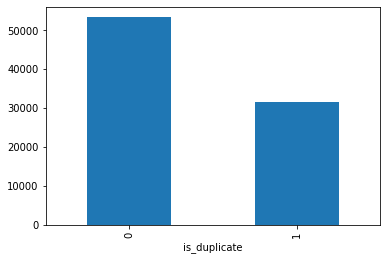

In [ ]:
# statiscal distribution of duplicate and non-duplicate data points overall.
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
#distribution of duplicate and non-duplicate data points overal

print('~> Total number of question pairs for training:\n   {}'.format(len(df)))
df['is_duplicate'].mean()
print('\n~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:
   84994

~> Question pairs are not Similar (is_duplicate = 0):
   62.77%

~> Question pairs are Similar (is_duplicate = 1):
   37.23%


In [ ]:
#check if there is any empty or null value in any data point.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84994 entries, 0 to 84993
Data columns (total 6 columns):
id              84994 non-null int64
qid1            84994 non-null int64
qid2            84994 non-null int64
question1       84994 non-null object
question2       84994 non-null object
is_duplicate    84994 non-null int64
dtypes: int64(4), object(2)
memory usage: 3.9+ MB


In [ ]:
# Identifying total number of questions, questions appearing more than one time and max no. times a question has occured

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}.3f%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are: 143600

Number of unique questions that appear more than one time: 15544 (10.824512534818941.3f%)

Max number of times a single question is repeated: 27



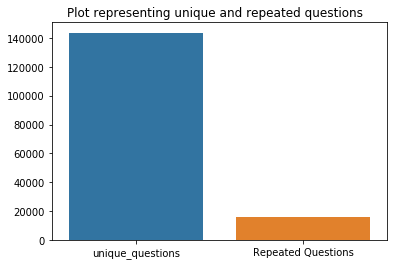

In [ ]:
# non-repeated vs repeated question distribution

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 27



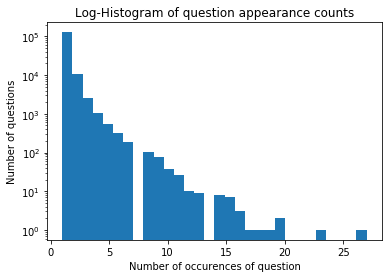

In [ ]:
#no. of questions vs no. of appearances

plt.hist(qids.value_counts(), bins=30)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [ ]:
#Checking whether there are any rows with null values
#df = df.fillna('')

nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>EDA with Basic Feature Extraction </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [ ]:
#insights from new features

print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])


Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 12
Number of Questions with minimum length [question2] : 5


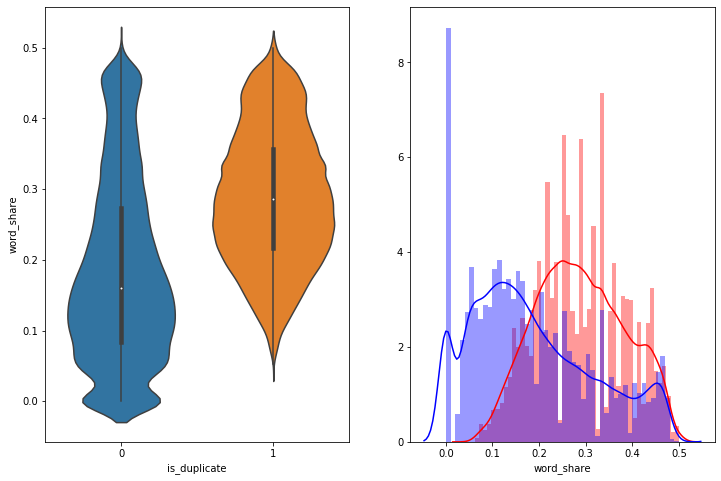

In [ ]:
#distribution of 'word_share feature' with duplicate and non-duplicate categories

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()



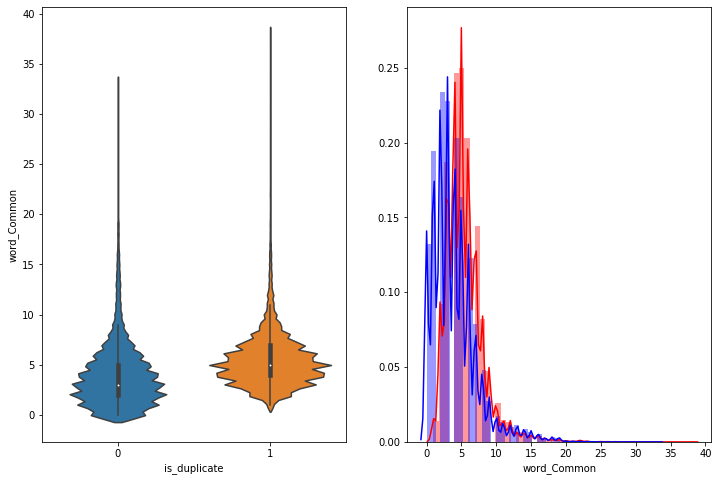

In [ ]:
#distribution of 'word_common' feature with duplicate and non-duplicate categories

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2>EDA with Advanced Feature Extraction (NLP and Fuzzy Features) and Text Preprocessing  </h2>

In [ ]:
# To get the results in 4 decemal points
from nltk.corpus import stopwords
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
#extracting features to a dataframe
if os.path.isfile('nlp_features_train_85K.csv'):
    df = pd.read_csv("nlp_features_train_85K.csv",encoding='latin-1')
    df.fillna('')
    print("NLP Features")
#else:
#    print("Extracting features for train:")
#    #df = pd.read_excel('train_85K.xlsx')
#    df = extract_features(df)
#    df.to_csv("nlp_features_train_85K.csv", index=False)
df.head(2)

NLP Features


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [ ]:
#extracting features to a dataframe
#df = extract_features(df)
#df.to_csv("nlp_features_train_85K.csv", index=False)
#df.head(2)

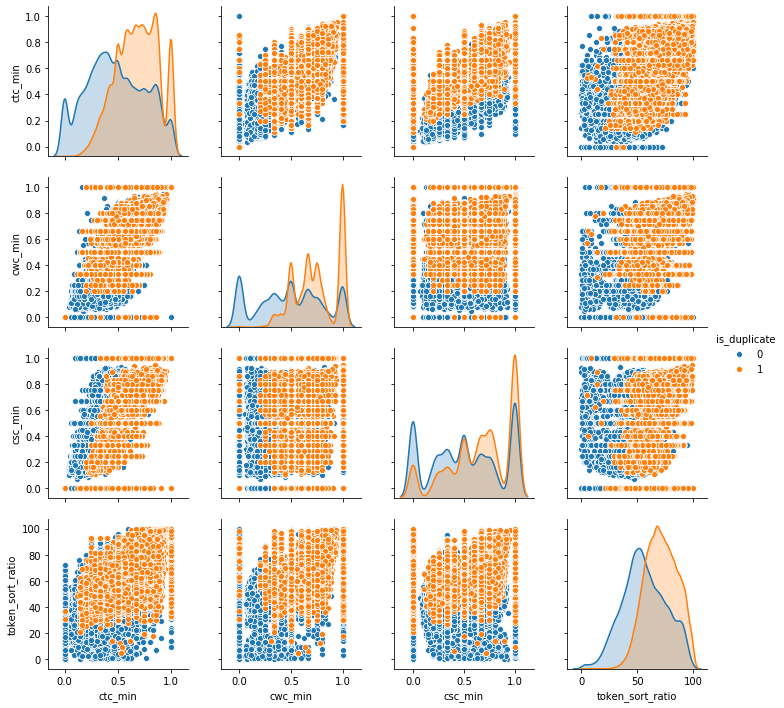

In [ ]:
#Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

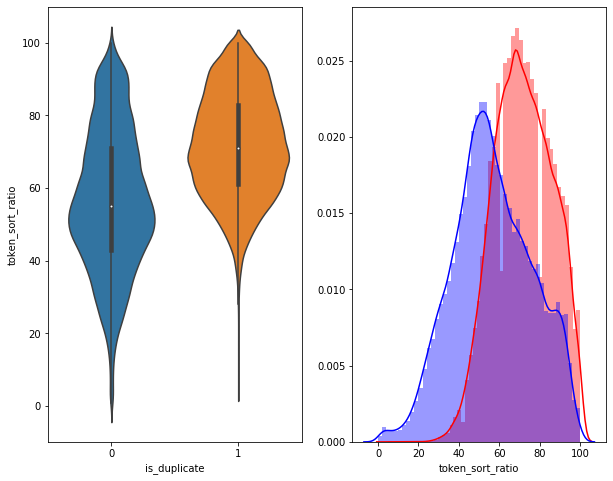

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

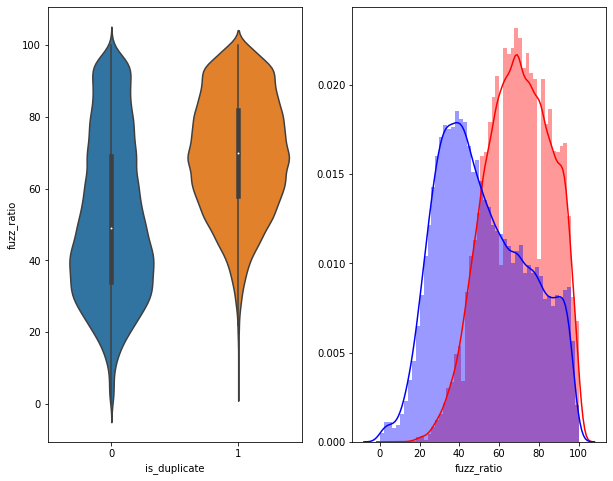

In [ ]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
#Converting the question to a string format
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2>Plotting a Python Word Cloud</h2>

In [ ]:
#creating a separate df for duplicate and non-duplicate datapoints

df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flattening the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding ='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding ='utf-8')

Number of data points in class 1 (duplicate pairs) : 63294
Number of data points in class 0 (non duplicate pairs) : 106694


In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

#textp_w = open(path.join(d, 'train_p.txt')).read()
#textn_w = open(path.join(d, 'train_n.txt')).read()
textp_w = open('train_p.txt', encoding="utf8").read()
textn_w = open('train_n.txt', encoding="utf8").read()

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 3412361
Total number of words in non duplicate pair questions : 6936219


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


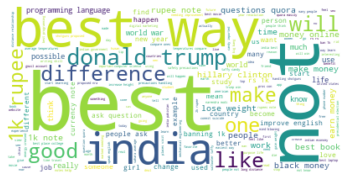

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


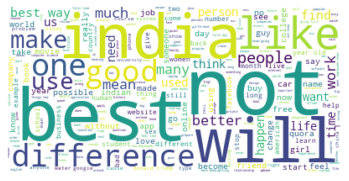

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>Train-Test Split</h2>

In [ ]:
#taking the only datapoints where words in q1 and q2 are greater than two to make more sense

print (df.shape)
df=df[df.q1_n_words >2]
print (df.shape)
df=df[df.q2_n_words >2]
print (df.shape)

(84994, 32)
(84961, 32)
(84947, 32)


In [ ]:
# Split the 25% of the data as test data
from sklearn.model_selection import train_test_split

y=df['is_duplicate']
df_=df.drop(['is_duplicate'],axis=1)

df_train, df_test, y_train, y_test = train_test_split(df_, y, test_size=0.25) # this is random splitting

<h2>Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8896444350630488
Confusion Matrix is:
[[6657 6663]
 [3983 3946]]


Precision Matrix is:
[[0.62565789 0.62805165]
 [0.37434211 0.37194835]]


Recall Matrix is:
[[0.49977477 0.50022523]
 [0.50233321 0.49766679]]


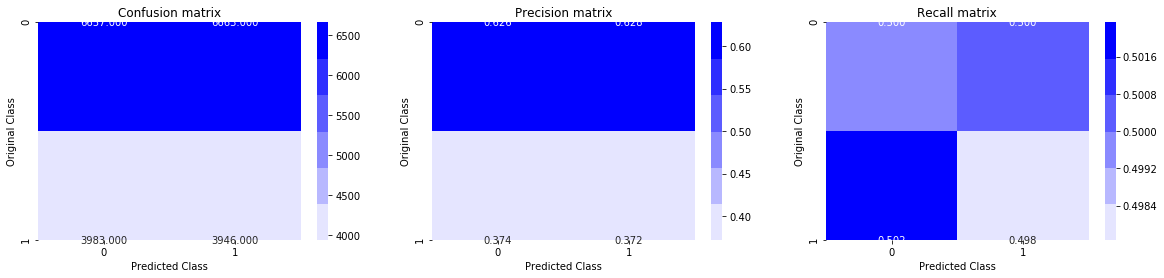

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

from sklearn.metrics.classification import log_loss

test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2>Applying Logistic Regression Algorithm</h2>

In [ ]:
X_train = df_train
X_test = df_test

In [ ]:
#TFIDF 
#fit has to happen only on train data

#vectorizer = TfidfVectorizer(ngram_range=(1,2),max_df=0.8, min_df=0.01, max_features=1000)
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
questions = list(set(X_train['question1'])) + list(set(X_train['question2']))
vectorizer.fit(questions) 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
# we use the fitted TfIDF Vectorizer to convert a text to vector
df_train_tfidf_q1 = vectorizer.transform(list(X_train['question1']))
df_train_tfidf_q2 = vectorizer.transform(list(X_train['question2']))
df_test_tfidf_q1 =  vectorizer.transform(list(X_test['question1']))
df_test_tfidf_q2 =  vectorizer.transform(list(X_test['question2']))

print("After vectorizations")
print(df_train_tfidf_q1.shape,df_train_tfidf_q2.shape, y_train.shape)
print(df_test_tfidf_q2.shape,df_test_tfidf_q2.shape, y_train.shape)
print("="*100)

After vectorizations
(63710, 1000) (63710, 1000) (63710,)
(21237, 1000) (21237, 1000) (63710,)


In [ ]:
#fit has to happen only on train data

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=900)
svd.fit(df_train_tfidf_q1+df_train_tfidf_q2)

TruncatedSVD(algorithm='randomized', n_components=900, n_iter=5,
             random_state=None, tol=0.0)

In [ ]:
#transforming a sparse matrix to a dense matrix
df_train_tfidf_q1_dense = svd.transform(df_train_tfidf_q1)
df_train_tfidf_q2_dense = svd.transform(df_train_tfidf_q2)
df_test_tfidf_q1_dense  = svd.transform(df_test_tfidf_q1)
df_test_tfidf_q2_dense  = svd.transform(df_test_tfidf_q2)

In [ ]:
#transforming a dense matrix to a dataframe
df_train_tfidf_q1_df = pd.DataFrame(df_train_tfidf_q1_dense)
df_train_tfidf_q2_df = pd.DataFrame(df_train_tfidf_q2_dense)
df_test_tfidf_q1_df  = pd.DataFrame(df_test_tfidf_q1_dense)
df_test_tfidf_q2_df  = pd.DataFrame(df_test_tfidf_q2_dense)

In [ ]:
# adding id column to all the above dataframes for merging at later stage

df_train_tfidf_q1_df['id']=X_train['id']
df_train_tfidf_q2_df['id']=X_train['id']
df_test_tfidf_q1_df['id']=X_test['id']
df_test_tfidf_q2_df['id']=X_test['id']

In [ ]:
# Merging all the q1 and q2 frames with the original frames and dropping the columns that are not required
# these will be the final frames

X_train = X_train.merge(df_train_tfidf_q1_df, on='id',how='left')
X_train = X_train.merge(df_train_tfidf_q2_df, on='id',how='left')
X_test = X_test.merge(df_test_tfidf_q1_df, on='id',how='left')
X_test = X_test.merge(df_test_tfidf_q2_df, on='id',how='left')

X_train = X_train.drop(['id','qid1','qid2','question1','question2'],axis=1)
X_test = X_test.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [ ]:
#imputing a missing value with the mean value
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
 
X_train=imp.fit_transform(X_train)
X_test=imp.transform(X_test)


In [ ]:
# Please write all the code with proper documentation

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


lg = LogisticRegression()
parameters={'penalty': ['l1','l2'], 'C': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01]}

clf=GridSearchCV(lg,parameters,scoring='roc_auc',return_train_score='True')
clf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='True',
             scoring='roc_auc', verbose=0)

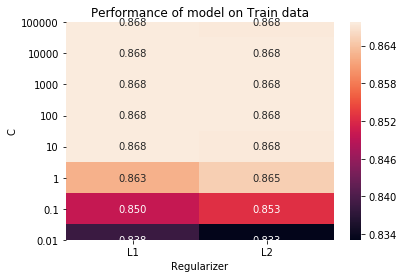

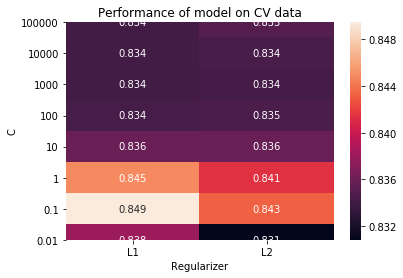

In [ ]:
#Hyperparameter tuning

import matplotlib.pyplot as plt
A=clf.cv_results_['mean_test_score']
B = np.reshape(A, (-1, 2))

C = clf.cv_results_['mean_train_score']
D = np.reshape(C, (-1, 2))

cx = sns.heatmap(D,annot=D,fmt="0.3f",xticklabels=['L1','L2'], yticklabels=[100000, 10000, 1000, 100, 10, 1, 0.1, 0.01])

plt.xlabel("Regularizer")
plt.ylabel("C")
plt.title("Performance of model on Train data")
plt.show()

ax = sns.heatmap(B,annot=True,fmt="0.3f",xticklabels=['L1','L2'], yticklabels=[100000, 10000, 1000, 100, 10, 1, 0.1, 0.01])

plt.xlabel("Regularizer")
plt.ylabel("C")
plt.title("Performance of model on CV data")
plt.show()

In [ ]:
print ("The best Estimator is")
print (clf.best_estimator_)
print ("\n")
print ("ROC_AUC score obtained by the best estimator on CV data")
print (clf.best_score_)

The best Estimator is
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


ROC_AUC score obtained by the best estimator on CV data
0.8494607129089043


In [ ]:
y_predict_train = clf.predict_proba(X_train)[:,1]
y_predict_test = clf.predict_proba(X_test)[:,1]

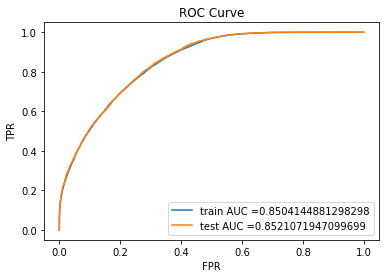

In [ ]:
#AUC on the train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_predict_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_predict_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    
    print ("Confusion Matrix is:")
    print (C)
    print ("\n")
    print ("Precision Matrix is:")
    print (B)
    print ("\n")
    print ("Recall Matrix is:")
    print (A)
    
    plt.show()

Log loss on Test Data using Logistic regression 0.4520749835252185


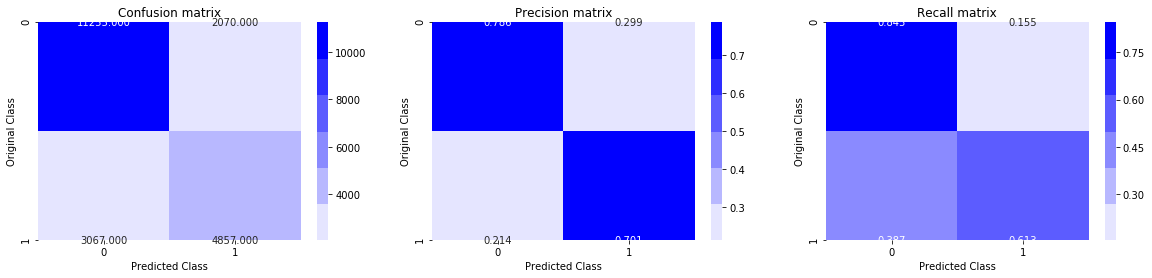

In [ ]:
from sklearn.metrics.classification import log_loss

print("Log loss on Test Data using Logistic regression",log_loss(y_test, y_predict_test, eps=1e-15))
plot_confusion_matrix(y_test, clf.predict(X_test))

<h2>Applying XGBoost Algorithm</h2>

In [ ]:
X_train = df_train
X_test = df_test

In [ ]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
# word2vec train q1
import spacy
nlp = spacy.load('en_core_web_sm') 

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(X_train['question1']):
    doc1 = nlp(qu1) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)


In [ ]:
# word2vec train q2
vecs2 = []
for qu2 in list(X_train['question2']):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

In [ ]:
# word2vec test q1


vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in list(X_test['question1']):
    doc1 = nlp(qu1) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)

In [ ]:
# word2vec test q2

vecs2 = []
for qu2 in list(X_test['question2']):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

In [ ]:
#Converting vector column to a dataframe

df_train_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
df_train_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)
df_test_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
df_test_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

# adding id column to all the dataframes for merging
df_train_q1['id'] = X_train['id']
df_train_q2['id'] = X_train['id']
df_test_q1['id'] = X_test['id']
df_test_q2['id'] = X_test['id']

In [ ]:
#merging the dataframes

X_train = X_train.merge(df_train_q1, on='id',how='left')
X_train = X_train.merge(df_train_q2, on='id',how='left')
X_test = X_test.merge(df_test_q1, on='id',how='left')
X_test = X_test.merge(df_test_q2, on='id',how='left')

In [ ]:
#dropping the columns that are not required to get the final data frame

X_train = X_train.drop(['id','qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)
X_test = X_test.drop(['id','qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)
X_train.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,1,1,90,149,16,27,8.0,40.0,0.200,2,...,79.542336,-9.349609,-17.416720,147.560170,19.261689,40.500069,24.847520,95.618102,-76.630138,-5.729342
1,1,1,15,22,4,4,3.0,8.0,0.375,2,...,29.096423,-15.271821,-17.359732,28.244953,-3.978002,22.452489,-19.868021,22.582628,-4.884448,18.678182


In [ ]:
print ("Number of features for question1 in the dataframe = ",df_train_q1.shape[1]-1) #substracting id column
print ("Number of features for question2 in the dataframe = ",df_train_q2.shape[1]-1)
print ("Number of NLP and Pre-processed features in the dataframe = ",X_train.shape[1] - (df_train_q1.shape[1] -1) - (df_train_q2.shape[1]-1))

Number of features for question1 in the dataframe =  96
Number of features for question2 in the dataframe =  96
Number of NLP and Pre-processed features in the dataframe =  26


In [ ]:
# Apply the XGBoost algorithm on the train data

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

xgb=XGBClassifier()
parameters={'n_estimators': [50,100,200,300,400], 'max_depth': [1,2,3,4,5]}

clf=GridSearchCV(xgb,parameters,scoring='roc_auc',return_train_score='True')
clf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [50, 100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', r

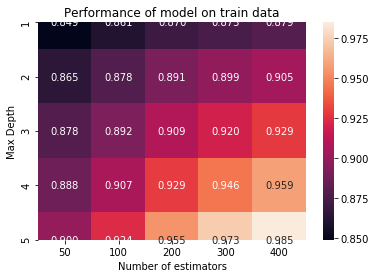

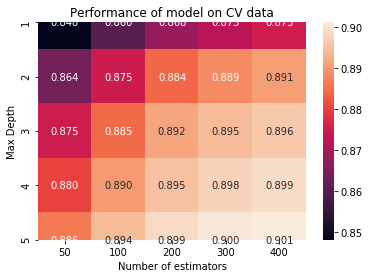

In [ ]:
#Hyperparameter tuning

A=clf.cv_results_['mean_test_score']
B = np.reshape(A, (-1, 5))

C = clf.cv_results_['mean_train_score']
D = np.reshape(C, (-1, 5))

cx = sns.heatmap(D,annot=True,fmt="0.3f",xticklabels=[50,100,200,300,400], yticklabels=[1,2,3,4,5])

plt.xlabel("Number of estimators")
plt.ylabel("Max Depth")
plt.title("Performance of model on train data")
plt.show()

ax = sns.heatmap(B,annot=True,fmt="0.3f",xticklabels=[50,100,200,300,400], yticklabels=[1,2,3,4,5])

plt.xlabel("Number of estimators")
plt.ylabel("Max Depth")
plt.title("Performance of model on CV data")
plt.show()

In [ ]:
print ("The best Estimator is")
print (clf.best_estimator_)
print ("\n")
print ("ROC_AUC score obtained by the best estimator on CV data")
print (clf.best_score_)

The best Estimator is
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


ROC_AUC score obtained by the best estimator on CV data
0.9011936026398314


In [ ]:
#predict the probability score with the best estimator

y_predict_train = clf.predict_proba(X_train)[:,1]
y_predict_test = clf.predict_proba(X_test)[:,1]

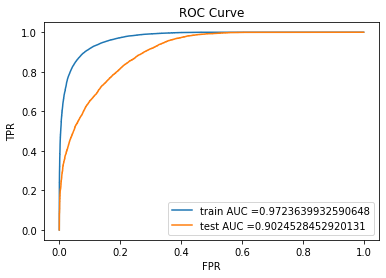

In [ ]:
#AUC on the train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_predict_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_predict_test)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()


Log loss on Test Data using Logistic regression 0.36853650066242616
Confusion Matrix is:
[[11406  1894]
 [ 2126  5811]]


Precision Matrix is:
[[0.84289093 0.24581441]
 [0.15710907 0.75418559]]


Recall Matrix is:
[[0.85759398 0.14240602]
 [0.26785939 0.73214061]]


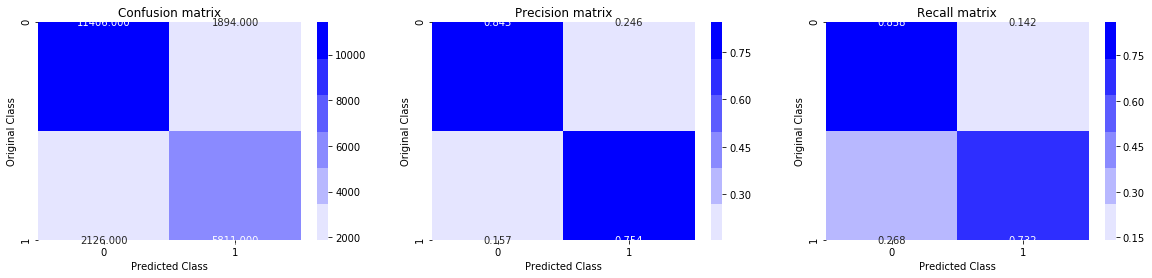

In [ ]:
#Calculate log loss and plot the confusion matrix
from sklearn.metrics.classification import log_loss

print("Log loss on Test Data using Logistic regression",log_loss(y_test, y_predict_test, eps=1e-15))
plot_confusion_matrix(y_test, clf.predict(X_test))

<h2> Conclusions </h2>

In [ ]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model","Vectorizer", "Log Loss", "AUC"]

x.add_row(["Random Model","NA",0.88, "NA"])
x.add_row(["Logistic Regression","TFIDF",0.45, 0.85])
x.add_row(["XGBoost","TFIDF W2V",0.368, 0.90])


print("Performance of Models")
print(x)
print("\n\nBest result is with XGBoost Model with TFIDF W2V vectorizer having Log-Loss = 0.368 and AUC = 0.90 ")

Performance of Models
+---------------------+------------+----------+------+
|        Model        | Vectorizer | Log Loss | AUC  |
+---------------------+------------+----------+------+
|     Random Model    |     NA     |   0.88   |  NA  |
| Logistic Regression |   TFIDF    |   0.45   | 0.85 |
|       XGBoost       | TFIDF W2V  |  0.368   | 0.9  |
+---------------------+------------+----------+------+


Best result is with XGBoost Model with TFIDF W2V vectorizer having Log-Loss = 0.368 and AUC = 0.90 


<h2>Step by step procedure to complete this Project</h2>


<br><br>
- Imported a CSV file into Spotfire and filtered out the data to have 85K datapoints in the ratio of 5:3 (0/1)
- Used the exported CSV file to load the data in pandas dataframe.
- Did an EDA with the available features.
- For example, the distribution of duplicate vs non-duplicate pairs.
- Another example, no. of questions that appeared only one time and no. of questions that appeared more than once.
- One more example, plotted log-histogram of counts of question appearance.
<br><br>
- Performed a Basic feature extraction to get new features like frequency of questions in question1 or question2, etc. Here is the list of all those features with its description.
- freq_qid1 = Frequency of qid1's
- freq_qid2  = Frequency of qid2's 
- q1len  = Length of q1
- q2len  = Length of q2
- q1_n_words  = Number of words in Question 1
- q2_n_words  = Number of words in Question 2
- word_Common  = (Number of common unique words in Question 1 and Question 2)
- word_Total  =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share  = (word_common)/(word_Total)
- freq_q1+freq_q2  = sum total of frequency of qid1 and qid2 
- freq_q1-freq_q2  = absolute difference of frequency of qid1 and qid2 
<br><br>
- Performed an EDA on the above features.
- distribution of 'word_share feature' with duplicate and non-duplicate categories.
- distribution of 'word_common' feature with duplicate and non-duplicate categories.
<br><br>
- Performed Preprocessing and Advanced feature extraction to get NLP and Fuzzy features. Here is the list of all those features with its description.
- cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
- cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
- csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
- csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
- ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
- ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
- last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
- first_word_eq = int(q1_tokens[0] == q2_tokens[0])
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
- mean_len = (len(q1_tokens) + len(q2_tokens))/2
- fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
- longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))
<br><br>
- Stored all the features in nlp_features_train_85K.csv file
- Performed an EDA on the above features.
- Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] with hue='is_duplicate'.
- Distribution of the token_sort_ratio with duplicate and non-duplicate categories.
- Distribution of the fuzz_ratio with duplicate and non-duplicate categories.
<br><br>
- Plotted a word cloud to get the top words from the frames with duplicate and non-duplicate categories separately.
<br><br>
- Took only datapoints where words in q1 and q2 are greater than two to make more sense.
- Did a train-test split (75%-25%).
<br><br>
- Build a Random Model with log loss = 0.89 to set the benchmark.
<br><br>
- Applied Logistic Regression on Trained data. Following are the steps.
- Took a UNIQUE set of values (question1 + question2) from X_train and applied TF-IDF vectorizer.
- Transformed the train and test data to get the vector representation.
- Dimension of question1 = 1000 and Dimension of question2 = 1000.
- Converted the sparse matrix to dense matrix (with 900 dim each) and then converted the dense matrix to a dataframe.
- Merge the individual frames to form a final dataframe with 1826(26 + 900 + 900) dimensions.
- Removed the columns that are not required.
- imputed a missing value with the mean value.
- Applied Logistic regression on train data with hyper-parameter tuning using grid search.
- Best C = 0.1 and penalty = L1
- AUC = 0.85 and Log loss = 0.45
<br><br>
- Applied XGBoost Algorithm on trained data. Following are the steps.
- Used the same TF-IDF vectorizer to get the feature names and IDF score. 
- Used spacy library (en_core_web_sm) to get the features for question1 and question2 (96 is the number of dimensions of vectors).
- Converted vector column to a dataframe.
- Merged the columns to form a final dataframe and removed the columns that are not required.
- Total no. of features = 218 (26 + 96 + 96)
- Applied XGBoost algorithm on train data with hyper-parameter tuning using grid search.
- Best max_depth=5 and n_estimators=400
- AUC = 0.90 and Log loss =  0.368